In [1]:
# imports required for the algorithm
import os

from pandas import read_csv
from pandas import DataFrame
from pandas import concat

from datetime import datetime
from math import sqrt
import numpy as np

from matplotlib import pyplot

from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

Using TensorFlow backend.


In [2]:
# path to load and save data
data_input_path = '../data_in/CE_Crateus.csv'
data_output_path = '../data_out/weather.csv'
data_output_path_npsave = '../data_out/weather.npy'

In [3]:
# transform date into appropriate format
def parse(x):
	return datetime.strptime(x, '%d/%m/%Y')

In [4]:
# load the input dataset and save like a output dataset
def format_dataset(data_input_path, output_path):
    try:
        dataset = read_csv(data_input_path, parse_dates=['Data'], index_col=1, date_parser=parse, encoding='latin-1')
    except:
        dataset = read_csv(data_input_path, parse_dates=['Data'], index_col=1, date_parser=parse, encoding='latin-1', skiprows=2)
    
    dataset.index.name = 'date'

    dataset.drop('Unnamed: 11', axis=1, inplace=True)
    dataset.drop('Estacao', axis=1, inplace=True)
    
    dataset['TempMinima'] = dataset['TempMinima'].shift(-1)
    dataset['Precipitacao'] = dataset['Precipitacao'].shift(-1)
    
    dataset.drop('Hora', axis=1, inplace=True)
    
    dataset = dataset.loc[~dataset.index.duplicated(keep='first')]
    
    # delete all NA values
    dataset[:].fillna(0, inplace=True)

    # show the first 5 lines on the dataset
    print(dataset.head())
        
    # save file
    dataset.to_csv(output_path)

format_dataset(data_input_path, data_output_path)

            Precipitacao  TempMaxima  TempMinima  Insolacao  Evaporacao Piche  \
date                                                                            
2015-01-01           0.0        35.0        23.7        5.9               0.0   
2015-01-02           0.0        35.8        23.0       10.6              10.2   
2015-01-03          37.4        31.9        22.3        4.3               6.2   
2015-01-04          12.4        27.3        20.7        1.9               3.5   
2015-01-05          23.0        32.4        20.7        8.3               1.5   

            Temp Comp Media  Umidade Relativa Media  Velocidade do Vento Media  
date                                                                            
2015-01-01            28.76                   47.00                   2.633333  
2015-01-02            26.72                   72.50                   1.866667  
2015-01-03            26.32                   71.50                   1.600000  
2015-01-04            23.50

In [5]:
# load dataset
def load_dataset(input_path):
    return read_csv(input_path, header=0, index_col=0)

dataset = load_dataset(data_output_path)
values = dataset.values

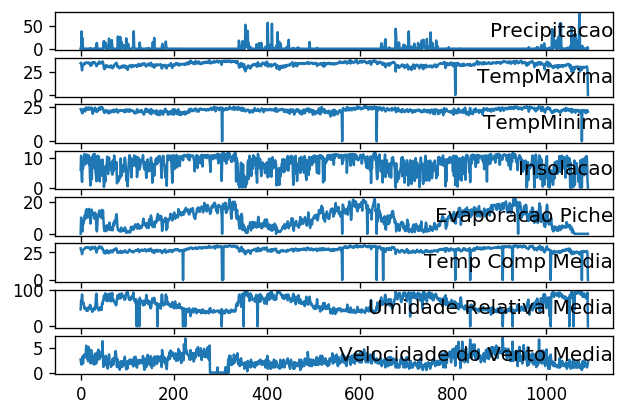

In [6]:
# plot each column in a graph
def plot_columns(values):
    groups = list(range(0,len(values[0])))
    i = 1
    
    pyplot.figure(dpi=120)
    for group in groups:
        pyplot.subplot(len(groups), 1, i)
        pyplot.plot(values[:, group])
        pyplot.title(dataset.columns[group], y=0.1, loc='right')
        i += 1
    pyplot.show()

plot_columns(values)

In [7]:
def series_to_supervised(dataset, day):
    y_test = np.array([dataset.loc[day]['TempMaxima'], dataset.loc[day]['TempMinima']])
    y_test = y_test.reshape(1,2)
    
    dataset = dataset[:-1]
    
    x_test = np.array(dataset[-60:])
    x_test = x_test.reshape(1,60,8)
    
    lista = []
    
    for i in list(dataset.index):
        lista.append([dataset.loc[i]['TempMaxima'], dataset.loc[i]['TempMinima']])
    y_train = np.array(lista[60:])
    
    dataset = dataset[:-1]
    
    x_train = np.array(dataset[-60:])
    x_train = x_train.reshape(1,60,8)
    dataset = dataset[:-1]
    
    while len(dataset) >= 60:
        array_aux = np.array(dataset[-60:])
        array_aux = array_aux.reshape(1,60,8)
        x_train = np.concatenate((x_train, array_aux), axis=0)
        dataset = dataset[:-1]
    
    return (x_train, y_train, x_test, y_test)

In [8]:
# inner loop
def myLSTM(x_train, y_train, x_test, y_test):
    x_val = x_train[-1]
    y_val = y_train[-1]
    x_val = x_val.reshape(1,60,8)
    y_val = y_val.reshape(1,2)
    x_train = x_train[:-1]
    y_train = y_train[:-1]
    
    # design network
    model = Sequential()
    model.add(LSTM(50, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dense(16, activation='relu'))   # worth it?
    model.add(Dense(2))
    model.compile(loss='mae', optimizer='adam', metrics=['mse'])

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, verbose=0, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')
    ]

    # fit network
    history = model.fit(x_train, y_train,
                        epochs=1000, 
                        batch_size=72, 
                        validation_data=(x_val, y_val), 
                        verbose=2, 
                        shuffle=True, 
                        callbacks=callbacks)

    # plot history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()
    
    # make a prediction
    y_hat = model.predict(x_test)
    
    print('\npredict: {}'.format(y_hat))
    print('real:      {}\n'.format(y_test))
    
    return model

In [9]:
# calculate metrics
def metrics(model, x_test, y_test):
    y_hat = model.predict(x_test)
    
    rmse = sqrt(mean_squared_error(y_test, y_hat))
    variance = explained_variance_score(y_test, y_hat)
    maxError = np.max(np.abs(y_test - y_hat))
    meanAbsolutError = mean_absolute_error(y_test, y_hat)
    medianAbsoluteError = np.median(np.abs(y_test - y_hat))
    
    return [rmse, variance, maxError, meanAbsolutError, medianAbsoluteError]

In [10]:
# Nested Cross Validation
def NCV(dataset, days_to_predict):
    metrics_list = []
    rmse = []
    variance = []
    maxError = []
    meanAbsolutError = []
    medianAbsoluteError = []
    i = len(days_to_predict) - 1
    
    # outer loop
    while(i >= 0):
        data = series_to_supervised(dataset, days_to_predict[i])
        x_train = data[0]
        y_train = data[1]
        x_test = data[2]
        y_test = data[3]

        model = myLSTM(x_train, y_train, x_test, y_test)    
        metrics_list += metrics(model, x_test, y_test)
        
        rmse += [metrics_list[0]]
        variance += [metrics_list[1]]
        maxError += [metrics_list[2]]
        meanAbsolutError += [metrics_list[3]]
        medianAbsoluteError += [metrics_list[4]]
        
        i -= 1
        dataset = dataset[:-1]
        
    print('Test RMSE -------------------------- {:.4}'.format(np.mean(rmse)))
    print('Test VARIANCE ---------------------- {:.4}'.format(np.mean(variance)))
    print('Test MAX-ERROR --------------------- {:.4}'.format(np.mean(maxError)))
    print('Test MEAN-ABSOLUTE-ERROR ----------- {:.4}'.format(np.mean(meanAbsolutError)))
    print('Test MEDIAN-ABSOLUTE-ERROR --------- {:.4}'.format(np.mean(medianAbsoluteError)))

Train on 1029 samples, validate on 1 samples
Epoch 1/1000
 - 0s - loss: 27.5753 - mean_squared_error: 801.1661 - val_loss: 24.3576 - val_mean_squared_error: 607.2153
Epoch 2/1000
 - 0s - loss: 26.1887 - mean_squared_error: 728.2713 - val_loss: 23.3257 - val_mean_squared_error: 557.6496
Epoch 3/1000
 - 0s - loss: 25.0032 - mean_squared_error: 670.2542 - val_loss: 21.7126 - val_mean_squared_error: 488.3622
Epoch 4/1000
 - 0s - loss: 23.5624 - mean_squared_error: 605.4837 - val_loss: 20.1980 - val_mean_squared_error: 428.4387
Epoch 5/1000
 - 0s - loss: 21.5536 - mean_squared_error: 521.1934 - val_loss: 17.7236 - val_mean_squared_error: 339.1010
Epoch 6/1000
 - 0s - loss: 18.5994 - mean_squared_error: 413.1150 - val_loss: 14.2927 - val_mean_squared_error: 239.8164
Epoch 7/1000
 - 0s - loss: 15.7912 - mean_squared_error: 330.4430 - val_loss: 11.6209 - val_mean_squared_error: 181.4021
Epoch 8/1000
 - 0s - loss: 12.9932 - mean_squared_error: 265.5129 - val_loss: 8.7007 - val_mean_squared_erro

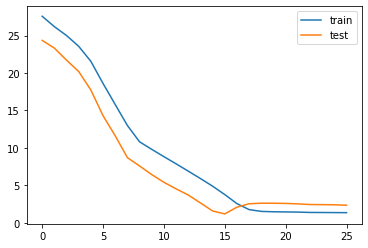


predict: [[29.702724 24.196983]]
real:      [[ 0.  21.9]]

Train on 1028 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 28.2373 - mean_squared_error: 832.6667 - val_loss: 26.1274 - val_mean_squared_error: 705.8320
Epoch 2/1000
 - 0s - loss: 27.7344 - mean_squared_error: 806.1661 - val_loss: 25.4787 - val_mean_squared_error: 675.3102
Epoch 3/1000
 - 0s - loss: 26.9806 - mean_squared_error: 766.2026 - val_loss: 24.4341 - val_mean_squared_error: 624.8539
Epoch 4/1000
 - 0s - loss: 25.8668 - mean_squared_error: 708.8498 - val_loss: 23.2207 - val_mean_squared_error: 568.6974
Epoch 5/1000
 - 0s - loss: 24.6371 - mean_squared_error: 647.8932 - val_loss: 21.8840 - val_mean_squared_error: 508.8199
Epoch 6/1000
 - 0s - loss: 23.1095 - mean_squared_error: 577.5834 - val_loss: 20.1315 - val_mean_squared_error: 438.5934
Epoch 7/1000
 - 0s - loss: 21.1378 - mean_squared_error: 495.4178 - val_loss: 17.9844 - val_mean_squared_error: 361.0933
Epoch 8/1000
 - 0s - loss: 18.4730 - mean_square

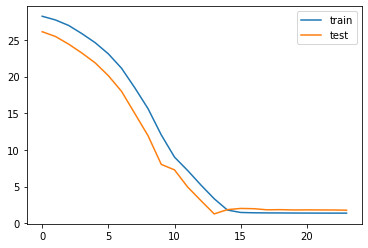


predict: [[30.54026  23.274868]]
real:      [[28.9 22.7]]

Train on 1027 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 28.0612 - mean_squared_error: 828.5578 - val_loss: 26.3846 - val_mean_squared_error: 717.9416
Epoch 2/1000
 - 0s - loss: 26.6196 - mean_squared_error: 749.2797 - val_loss: 25.1130 - val_mean_squared_error: 653.6776
Epoch 3/1000
 - 0s - loss: 25.2721 - mean_squared_error: 681.8437 - val_loss: 23.4948 - val_mean_squared_error: 579.6256
Epoch 4/1000
 - 0s - loss: 23.6768 - mean_squared_error: 609.1743 - val_loss: 21.5946 - val_mean_squared_error: 499.3521
Epoch 5/1000
 - 0s - loss: 21.8116 - mean_squared_error: 531.5430 - val_loss: 19.7010 - val_mean_squared_error: 427.7659
Epoch 6/1000
 - 0s - loss: 19.5871 - mean_squared_error: 448.6703 - val_loss: 17.2372 - val_mean_squared_error: 345.7037
Epoch 7/1000
 - 0s - loss: 17.2987 - mean_squared_error: 373.6448 - val_loss: 14.6985 - val_mean_squared_error: 273.7527
Epoch 8/1000
 - 0s - loss: 14.5571 - mean_square

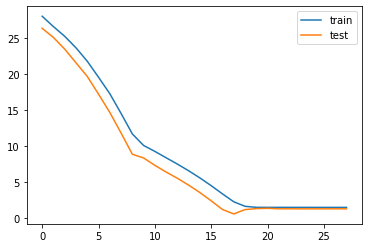


predict: [[32.31487  23.475819]]
real:      [[31.3 21.5]]

Train on 1026 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 27.7527 - mean_squared_error: 806.8035 - val_loss: 24.9670 - val_mean_squared_error: 650.9651
Epoch 2/1000
 - 0s - loss: 26.3745 - mean_squared_error: 735.1760 - val_loss: 23.3655 - val_mean_squared_error: 573.5011
Epoch 3/1000
 - 0s - loss: 24.5868 - mean_squared_error: 648.0780 - val_loss: 20.9430 - val_mean_squared_error: 472.1120
Epoch 4/1000
 - 0s - loss: 22.1913 - mean_squared_error: 541.5636 - val_loss: 18.6275 - val_mean_squared_error: 389.9552
Epoch 5/1000
 - 0s - loss: 19.4477 - mean_squared_error: 438.8646 - val_loss: 15.5033 - val_mean_squared_error: 295.8536
Epoch 6/1000
 - 0s - loss: 16.3649 - mean_squared_error: 340.1209 - val_loss: 12.2578 - val_mean_squared_error: 216.0118
Epoch 7/1000
 - 0s - loss: 12.5750 - mean_squared_error: 245.5494 - val_loss: 9.0799 - val_mean_squared_error: 147.1308
Epoch 8/1000
 - 0s - loss: 10.0508 - mean_squared

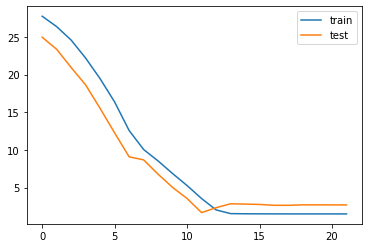


predict: [[30.183311 23.31203 ]]
real:      [[31.7 22.9]]

Train on 1025 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 28.1106 - mean_squared_error: 828.0180 - val_loss: 25.3805 - val_mean_squared_error: 667.1961
Epoch 2/1000
 - 0s - loss: 27.3439 - mean_squared_error: 782.9713 - val_loss: 24.2952 - val_mean_squared_error: 612.4514
Epoch 3/1000
 - 0s - loss: 26.1550 - mean_squared_error: 719.7556 - val_loss: 22.9106 - val_mean_squared_error: 548.1361
Epoch 4/1000
 - 0s - loss: 24.5579 - mean_squared_error: 640.0040 - val_loss: 21.2175 - val_mean_squared_error: 475.1555
Epoch 5/1000
 - 0s - loss: 22.6517 - mean_squared_error: 551.6174 - val_loss: 18.8004 - val_mean_squared_error: 380.1617
Epoch 6/1000
 - 0s - loss: 19.9923 - mean_squared_error: 439.2418 - val_loss: 16.1410 - val_mean_squared_error: 288.4777
Epoch 7/1000
 - 0s - loss: 16.8373 - mean_squared_error: 324.4692 - val_loss: 12.4186 - val_mean_squared_error: 184.3356
Epoch 8/1000
 - 0s - loss: 13.4218 - mean_square

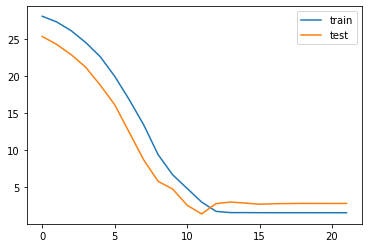


predict: [[31.462826 22.920273]]
real:      [[31.  20.8]]

Train on 1024 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 27.7199 - mean_squared_error: 797.3978 - val_loss: 24.7434 - val_mean_squared_error: 626.0757
Epoch 2/1000
 - 0s - loss: 26.4112 - mean_squared_error: 726.5855 - val_loss: 23.5288 - val_mean_squared_error: 570.2454
Epoch 3/1000
 - 0s - loss: 25.2550 - mean_squared_error: 667.9160 - val_loss: 22.3857 - val_mean_squared_error: 516.4435
Epoch 4/1000
 - 0s - loss: 23.9898 - mean_squared_error: 605.2962 - val_loss: 20.8921 - val_mean_squared_error: 450.5086
Epoch 5/1000
 - 0s - loss: 22.2950 - mean_squared_error: 524.8883 - val_loss: 19.0794 - val_mean_squared_error: 376.4781
Epoch 6/1000
 - 0s - loss: 20.2904 - mean_squared_error: 438.4077 - val_loss: 16.9755 - val_mean_squared_error: 301.2223
Epoch 7/1000
 - 0s - loss: 17.9914 - mean_squared_error: 349.3161 - val_loss: 14.4495 - val_mean_squared_error: 220.8775
Epoch 8/1000
 - 0s - loss: 15.2977 - mean_square

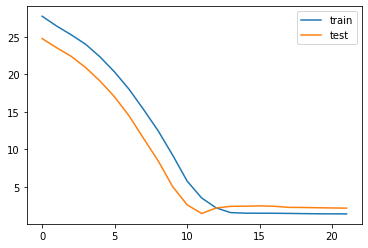


predict: [[30.30026 24.30122]]
real:      [[30.7 21. ]]

Train on 1023 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 27.8710 - mean_squared_error: 808.6753 - val_loss: 24.9663 - val_mean_squared_error: 636.9327
Epoch 2/1000
 - 0s - loss: 26.7926 - mean_squared_error: 751.3560 - val_loss: 24.2581 - val_mean_squared_error: 601.9957
Epoch 3/1000
 - 0s - loss: 25.8183 - mean_squared_error: 699.8192 - val_loss: 23.0565 - val_mean_squared_error: 543.6119
Epoch 4/1000
 - 0s - loss: 24.2846 - mean_squared_error: 621.6906 - val_loss: 21.6084 - val_mean_squared_error: 480.1245
Epoch 5/1000
 - 0s - loss: 22.6865 - mean_squared_error: 544.0606 - val_loss: 19.9230 - val_mean_squared_error: 407.6881
Epoch 6/1000
 - 0s - loss: 20.7613 - mean_squared_error: 456.6411 - val_loss: 17.7454 - val_mean_squared_error: 323.6257
Epoch 7/1000
 - 0s - loss: 17.7501 - mean_squared_error: 337.4254 - val_loss: 13.9157 - val_mean_squared_error: 199.9413
Epoch 8/1000
 - 0s - loss: 14.4860 - mean_squared_

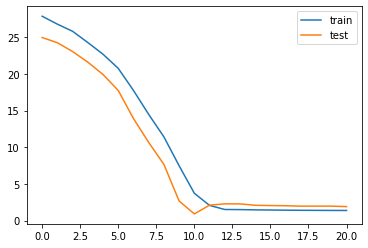


predict: [[30.405666 24.016819]]
real:      [[30.6 21.7]]

Train on 1022 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 28.4679 - mean_squared_error: 851.2980 - val_loss: 26.1151 - val_mean_squared_error: 693.3992
Epoch 2/1000
 - 0s - loss: 27.3996 - mean_squared_error: 788.0666 - val_loss: 25.1744 - val_mean_squared_error: 645.0684
Epoch 3/1000
 - 0s - loss: 26.4292 - mean_squared_error: 736.4155 - val_loss: 23.9272 - val_mean_squared_error: 586.7770
Epoch 4/1000
 - 0s - loss: 25.2924 - mean_squared_error: 676.9991 - val_loss: 22.7781 - val_mean_squared_error: 530.9762
Epoch 5/1000
 - 0s - loss: 24.0764 - mean_squared_error: 614.0674 - val_loss: 21.5259 - val_mean_squared_error: 473.3945
Epoch 6/1000
 - 0s - loss: 22.6248 - mean_squared_error: 544.2923 - val_loss: 19.9630 - val_mean_squared_error: 407.9060
Epoch 7/1000
 - 0s - loss: 21.0358 - mean_squared_error: 473.7816 - val_loss: 18.2415 - val_mean_squared_error: 341.6598
Epoch 8/1000
 - 0s - loss: 19.2873 - mean_square

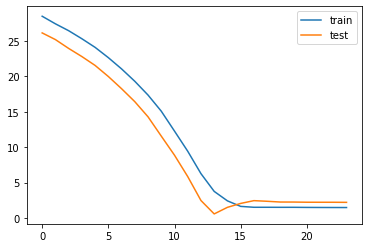


predict: [[29.773127 24.011698]]
real:      [[30.3 22.3]]

Train on 1021 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 28.2044 - mean_squared_error: 836.8021 - val_loss: 26.5602 - val_mean_squared_error: 725.9030
Epoch 2/1000
 - 0s - loss: 27.4511 - mean_squared_error: 794.4382 - val_loss: 25.8883 - val_mean_squared_error: 691.5417
Epoch 3/1000
 - 0s - loss: 26.6117 - mean_squared_error: 751.7197 - val_loss: 24.9440 - val_mean_squared_error: 645.4268
Epoch 4/1000
 - 0s - loss: 25.5012 - mean_squared_error: 697.2303 - val_loss: 23.6625 - val_mean_squared_error: 587.0877
Epoch 5/1000
 - 0s - loss: 23.9179 - mean_squared_error: 623.0633 - val_loss: 21.1448 - val_mean_squared_error: 481.1208
Epoch 6/1000
 - 0s - loss: 21.7845 - mean_squared_error: 534.6831 - val_loss: 19.2040 - val_mean_squared_error: 411.4073
Epoch 7/1000
 - 0s - loss: 19.7584 - mean_squared_error: 460.7433 - val_loss: 16.8910 - val_mean_squared_error: 336.4511
Epoch 8/1000
 - 0s - loss: 17.2698 - mean_square

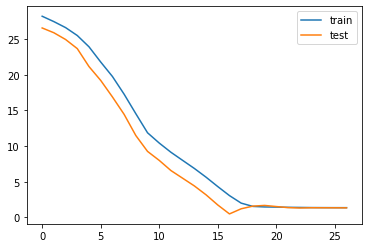


predict: [[30.721157 23.376698]]
real:      [[30.  23.1]]

Train on 1020 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 27.8181 - mean_squared_error: 809.1388 - val_loss: 25.9583 - val_mean_squared_error: 691.2868
Epoch 2/1000
 - 0s - loss: 27.1911 - mean_squared_error: 771.9304 - val_loss: 25.1788 - val_mean_squared_error: 649.1710
Epoch 3/1000
 - 0s - loss: 26.2855 - mean_squared_error: 721.5458 - val_loss: 24.1324 - val_mean_squared_error: 597.7339
Epoch 4/1000
 - 0s - loss: 24.9976 - mean_squared_error: 654.2974 - val_loss: 22.7629 - val_mean_squared_error: 533.2622
Epoch 5/1000
 - 0s - loss: 23.4038 - mean_squared_error: 576.2447 - val_loss: 20.8432 - val_mean_squared_error: 448.2953
Epoch 6/1000
 - 0s - loss: 21.8721 - mean_squared_error: 506.6679 - val_loss: 19.2515 - val_mean_squared_error: 384.8195
Epoch 7/1000
 - 0s - loss: 20.1785 - mean_squared_error: 435.5044 - val_loss: 17.3833 - val_mean_squared_error: 316.2830
Epoch 8/1000
 - 0s - loss: 18.1821 - mean_square

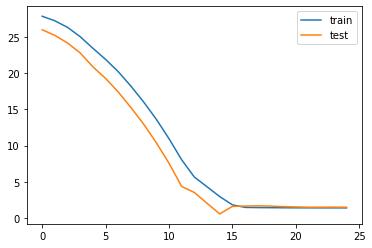


predict: [[30.899408 23.260225]]
real:      [[31.1 22.8]]

Train on 1019 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 28.2726 - mean_squared_error: 839.6180 - val_loss: 26.5578 - val_mean_squared_error: 724.7108
Epoch 2/1000
 - 0s - loss: 27.7303 - mean_squared_error: 812.9113 - val_loss: 26.0423 - val_mean_squared_error: 700.7142
Epoch 3/1000
 - 0s - loss: 27.1439 - mean_squared_error: 785.6461 - val_loss: 25.2842 - val_mean_squared_error: 667.8406
Epoch 4/1000
 - 0s - loss: 26.3733 - mean_squared_error: 748.3614 - val_loss: 24.2615 - val_mean_squared_error: 619.9304
Epoch 5/1000
 - 0s - loss: 25.2789 - mean_squared_error: 694.3892 - val_loss: 23.0980 - val_mean_squared_error: 566.4891
Epoch 6/1000
 - 0s - loss: 23.9033 - mean_squared_error: 628.5179 - val_loss: 21.5138 - val_mean_squared_error: 497.6371
Epoch 7/1000
 - 0s - loss: 22.0877 - mean_squared_error: 551.2936 - val_loss: 19.3589 - val_mean_squared_error: 416.5554
Epoch 8/1000
 - 0s - loss: 19.7738 - mean_square

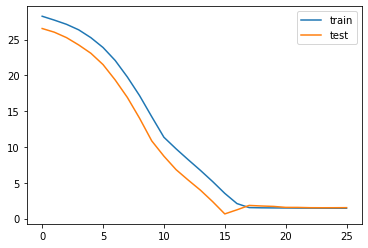


predict: [[30.12387 23.20821]]
real:      [[31.1 22.3]]

Train on 1018 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 28.3405 - mean_squared_error: 840.0055 - val_loss: 25.8816 - val_mean_squared_error: 690.9868
Epoch 2/1000
 - 0s - loss: 27.8156 - mean_squared_error: 810.1894 - val_loss: 25.2826 - val_mean_squared_error: 659.8792
Epoch 3/1000
 - 0s - loss: 27.0218 - mean_squared_error: 765.5947 - val_loss: 24.6057 - val_mean_squared_error: 624.9665
Epoch 4/1000
 - 0s - loss: 25.8807 - mean_squared_error: 703.9568 - val_loss: 23.2056 - val_mean_squared_error: 556.6566
Epoch 5/1000
 - 0s - loss: 23.9794 - mean_squared_error: 608.5513 - val_loss: 20.7366 - val_mean_squared_error: 448.4445
Epoch 6/1000
 - 0s - loss: 21.6903 - mean_squared_error: 502.6208 - val_loss: 18.3124 - val_mean_squared_error: 352.4774
Epoch 7/1000
 - 0s - loss: 19.3090 - mean_squared_error: 403.7999 - val_loss: 15.8528 - val_mean_squared_error: 267.6848
Epoch 8/1000
 - 0s - loss: 16.5620 - mean_squared_

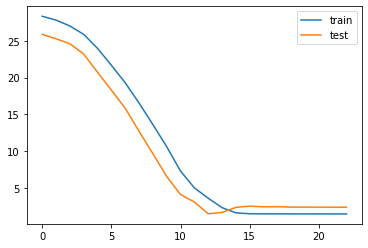


predict: [[29.919022 23.992737]]
real:      [[31.  22.8]]

Train on 1017 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 27.5134 - mean_squared_error: 795.9066 - val_loss: 14.4812 - val_mean_squared_error: 367.1762
Epoch 2/1000
 - 0s - loss: 26.3219 - mean_squared_error: 733.9490 - val_loss: 14.8373 - val_mean_squared_error: 351.1681
Epoch 3/1000
 - 0s - loss: 24.7224 - mean_squared_error: 653.3939 - val_loss: 14.6188 - val_mean_squared_error: 295.0449
Epoch 4/1000
 - 0s - loss: 22.9406 - mean_squared_error: 569.4070 - val_loss: 14.6731 - val_mean_squared_error: 270.5942
Epoch 5/1000
 - 0s - loss: 20.9367 - mean_squared_error: 484.0772 - val_loss: 14.9603 - val_mean_squared_error: 250.7664
Epoch 6/1000
 - 0s - loss: 18.6199 - mean_squared_error: 395.6263 - val_loss: 15.3586 - val_mean_squared_error: 242.6026
Epoch 7/1000
 - 0s - loss: 15.5338 - mean_squared_error: 294.6061 - val_loss: 15.5305 - val_mean_squared_error: 241.8409
Epoch 8/1000
 - 0s - loss: 11.7750 - mean_square

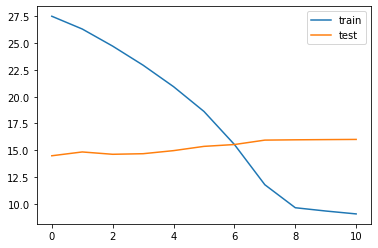


predict: [[0.33097035 1.102091  ]]
real:      [[30.7 21.7]]

Train on 1016 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 27.8651 - mean_squared_error: 809.4801 - val_loss: 25.3711 - val_mean_squared_error: 652.1806
Epoch 2/1000
 - 0s - loss: 26.9054 - mean_squared_error: 754.7942 - val_loss: 24.6788 - val_mean_squared_error: 617.7932
Epoch 3/1000
 - 0s - loss: 25.8603 - mean_squared_error: 699.3132 - val_loss: 23.1390 - val_mean_squared_error: 543.5211
Epoch 4/1000
 - 0s - loss: 23.8253 - mean_squared_error: 596.6424 - val_loss: 20.3087 - val_mean_squared_error: 418.7390
Epoch 5/1000
 - 0s - loss: 21.3210 - mean_squared_error: 479.4717 - val_loss: 17.7404 - val_mean_squared_error: 318.4047
Epoch 6/1000
 - 0s - loss: 18.9071 - mean_squared_error: 378.2866 - val_loss: 15.3351 - val_mean_squared_error: 237.4949
Epoch 7/1000
 - 0s - loss: 16.4434 - mean_squared_error: 288.1191 - val_loss: 12.7654 - val_mean_squared_error: 164.2879
Epoch 8/1000
 - 0s - loss: 13.6441 - mean_squa

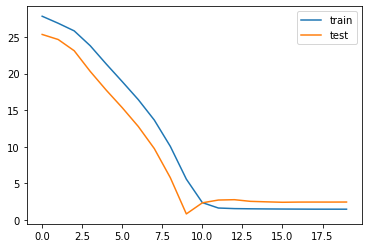


predict: [[29.072472 21.808376]]
real:      [[27.9  0. ]]

Train on 1015 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 28.4136 - mean_squared_error: 842.9961 - val_loss: 25.8970 - val_mean_squared_error: 685.9766
Epoch 2/1000
 - 0s - loss: 27.8336 - mean_squared_error: 804.7142 - val_loss: 25.2834 - val_mean_squared_error: 651.0790
Epoch 3/1000
 - 0s - loss: 27.0669 - mean_squared_error: 754.6486 - val_loss: 24.5641 - val_mean_squared_error: 611.3997
Epoch 4/1000
 - 0s - loss: 25.9822 - mean_squared_error: 688.5916 - val_loss: 23.3219 - val_mean_squared_error: 546.1756
Epoch 5/1000
 - 0s - loss: 24.5883 - mean_squared_error: 613.3501 - val_loss: 21.3375 - val_mean_squared_error: 455.4644
Epoch 6/1000
 - 0s - loss: 22.6787 - mean_squared_error: 519.8874 - val_loss: 19.3588 - val_mean_squared_error: 375.2230
Epoch 7/1000
 - 0s - loss: 20.4452 - mean_squared_error: 422.2739 - val_loss: 17.0047 - val_mean_squared_error: 291.9623
Epoch 8/1000
 - 0s - loss: 17.4607 - mean_square

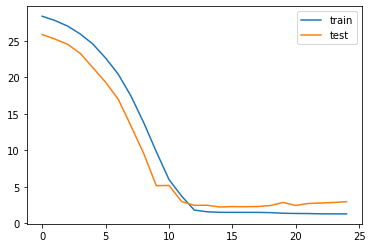


predict: [[34.251923 22.658566]]
real:      [[29.5 23. ]]

Train on 1014 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 28.6940 - mean_squared_error: 861.1577 - val_loss: 25.9869 - val_mean_squared_error: 705.6265
Epoch 2/1000
 - 0s - loss: 28.1085 - mean_squared_error: 833.7737 - val_loss: 25.4388 - val_mean_squared_error: 686.7150
Epoch 3/1000
 - 0s - loss: 27.4242 - mean_squared_error: 805.1068 - val_loss: 24.6574 - val_mean_squared_error: 654.0782
Epoch 4/1000
 - 0s - loss: 26.3619 - mean_squared_error: 749.9752 - val_loss: 23.2786 - val_mean_squared_error: 589.7388
Epoch 5/1000
 - 0s - loss: 24.8690 - mean_squared_error: 675.3601 - val_loss: 21.5756 - val_mean_squared_error: 517.4945
Epoch 6/1000
 - 0s - loss: 22.9767 - mean_squared_error: 589.2045 - val_loss: 19.3535 - val_mean_squared_error: 428.3716
Epoch 7/1000
 - 0s - loss: 20.5512 - mean_squared_error: 490.3024 - val_loss: 16.8117 - val_mean_squared_error: 344.8871
Epoch 8/1000
 - 0s - loss: 18.0758 - mean_square

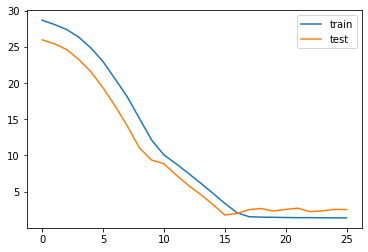


predict: [[30.23416  23.371305]]
real:      [[30.7 21.8]]

Train on 1013 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 28.2755 - mean_squared_error: 832.7600 - val_loss: 22.8667 - val_mean_squared_error: 526.6187
Epoch 2/1000
 - 0s - loss: 27.4842 - mean_squared_error: 786.2976 - val_loss: 22.2741 - val_mean_squared_error: 498.8688
Epoch 3/1000
 - 0s - loss: 26.5540 - mean_squared_error: 731.9353 - val_loss: 21.2588 - val_mean_squared_error: 453.7996
Epoch 4/1000
 - 0s - loss: 25.3860 - mean_squared_error: 668.1733 - val_loss: 20.0465 - val_mean_squared_error: 402.6996
Epoch 5/1000
 - 0s - loss: 24.1633 - mean_squared_error: 603.6725 - val_loss: 18.6695 - val_mean_squared_error: 348.7440
Epoch 6/1000
 - 0s - loss: 22.5071 - mean_squared_error: 521.9204 - val_loss: 16.6496 - val_mean_squared_error: 277.2860
Epoch 7/1000
 - 0s - loss: 20.7359 - mean_squared_error: 440.6284 - val_loss: 14.9117 - val_mean_squared_error: 223.3675
Epoch 8/1000
 - 0s - loss: 18.9774 - mean_square

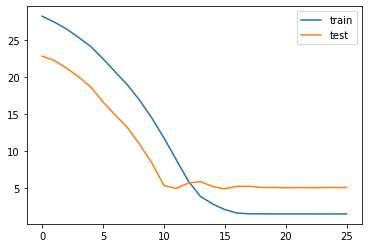


predict: [[35.12335 21.73823]]
real:      [[31.3 20.9]]

Train on 1012 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 27.7897 - mean_squared_error: 805.9707 - val_loss: 24.1861 - val_mean_squared_error: 599.4973
Epoch 2/1000
 - 0s - loss: 26.9243 - mean_squared_error: 759.1374 - val_loss: 23.2286 - val_mean_squared_error: 556.5365
Epoch 3/1000
 - 0s - loss: 25.6138 - mean_squared_error: 692.5672 - val_loss: 21.6795 - val_mean_squared_error: 487.5206
Epoch 4/1000
 - 0s - loss: 24.0773 - mean_squared_error: 618.1892 - val_loss: 20.0075 - val_mean_squared_error: 419.4325
Epoch 5/1000
 - 0s - loss: 22.4445 - mean_squared_error: 544.6627 - val_loss: 18.2224 - val_mean_squared_error: 352.8212
Epoch 6/1000
 - 0s - loss: 20.2996 - mean_squared_error: 456.9415 - val_loss: 15.8171 - val_mean_squared_error: 275.0569
Epoch 7/1000
 - 0s - loss: 17.7422 - mean_squared_error: 365.2911 - val_loss: 12.8557 - val_mean_squared_error: 194.3033
Epoch 8/1000
 - 0s - loss: 14.3083 - mean_squared_

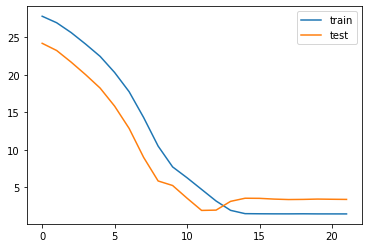


predict: [[27.145412 23.002916]]
real:      [[25.9 21.2]]

Train on 1011 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 27.6956 - mean_squared_error: 800.7124 - val_loss: 24.9887 - val_mean_squared_error: 643.8948
Epoch 2/1000
 - 0s - loss: 26.5133 - mean_squared_error: 734.0721 - val_loss: 24.0473 - val_mean_squared_error: 595.8775
Epoch 3/1000
 - 0s - loss: 25.3673 - mean_squared_error: 672.3933 - val_loss: 22.7607 - val_mean_squared_error: 533.5939
Epoch 4/1000
 - 0s - loss: 24.0303 - mean_squared_error: 603.2865 - val_loss: 21.3648 - val_mean_squared_error: 469.2917
Epoch 5/1000
 - 0s - loss: 22.0031 - mean_squared_error: 506.0088 - val_loss: 18.8492 - val_mean_squared_error: 364.7139
Epoch 6/1000
 - 0s - loss: 19.6215 - mean_squared_error: 402.6393 - val_loss: 16.3113 - val_mean_squared_error: 272.3872
Epoch 7/1000
 - 0s - loss: 17.3561 - mean_squared_error: 315.0300 - val_loss: 13.9372 - val_mean_squared_error: 198.0543
Epoch 8/1000
 - 0s - loss: 14.9293 - mean_square

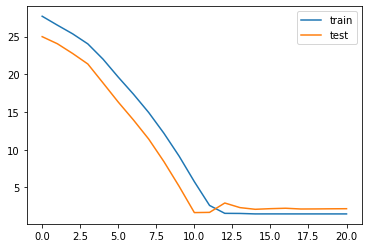


predict: [[29.700485 19.787102]]
real:      [[29.2 21.1]]

Train on 1010 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 27.2430 - mean_squared_error: 773.0361 - val_loss: 23.9873 - val_mean_squared_error: 578.8832
Epoch 2/1000
 - 0s - loss: 25.6279 - mean_squared_error: 684.4653 - val_loss: 22.3632 - val_mean_squared_error: 502.8594
Epoch 3/1000
 - 0s - loss: 24.0759 - mean_squared_error: 604.5600 - val_loss: 20.9199 - val_mean_squared_error: 439.9297
Epoch 4/1000
 - 0s - loss: 22.2292 - mean_squared_error: 516.3863 - val_loss: 18.8744 - val_mean_squared_error: 357.7979
Epoch 5/1000
 - 0s - loss: 19.5807 - mean_squared_error: 402.2979 - val_loss: 15.3697 - val_mean_squared_error: 236.3895
Epoch 6/1000
 - 0s - loss: 16.0984 - mean_squared_error: 271.8755 - val_loss: 11.7733 - val_mean_squared_error: 138.7842
Epoch 7/1000
 - 0s - loss: 12.5714 - mean_squared_error: 166.3796 - val_loss: 7.8258 - val_mean_squared_error: 63.0760
Epoch 8/1000
 - 0s - loss: 8.5706 - mean_squared_e

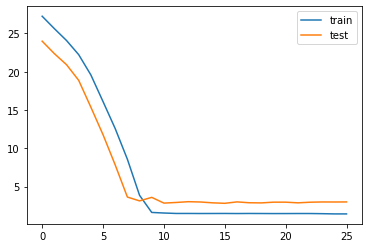


predict: [[34.126713 22.991098]]
real:      [[31.1 21.7]]

Train on 1009 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 27.4336 - mean_squared_error: 789.2335 - val_loss: 24.9510 - val_mean_squared_error: 639.8792
Epoch 2/1000
 - 0s - loss: 25.8387 - mean_squared_error: 702.1816 - val_loss: 23.7679 - val_mean_squared_error: 582.4966
Epoch 3/1000
 - 0s - loss: 23.9065 - mean_squared_error: 604.2548 - val_loss: 20.9748 - val_mean_squared_error: 455.2122
Epoch 4/1000
 - 0s - loss: 20.9558 - mean_squared_error: 468.7399 - val_loss: 17.6653 - val_mean_squared_error: 325.3887
Epoch 5/1000
 - 0s - loss: 17.4157 - mean_squared_error: 330.2726 - val_loss: 13.6022 - val_mean_squared_error: 196.8150
Epoch 6/1000
 - 0s - loss: 13.5778 - mean_squared_error: 207.8935 - val_loss: 9.4709 - val_mean_squared_error: 98.8549
Epoch 7/1000
 - 0s - loss: 8.9069 - mean_squared_error: 100.6652 - val_loss: 3.8141 - val_mean_squared_error: 20.9011
Epoch 8/1000
 - 0s - loss: 4.1488 - mean_squared_erro

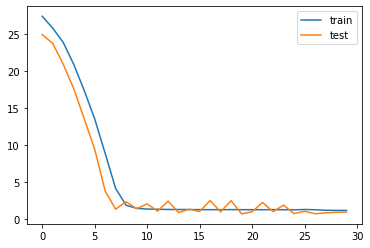


predict: [[32.441406 22.41249 ]]
real:      [[28.7 23.2]]

Train on 1008 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 28.3740 - mean_squared_error: 841.8602 - val_loss: 26.2696 - val_mean_squared_error: 711.7216
Epoch 2/1000
 - 0s - loss: 27.5437 - mean_squared_error: 797.5342 - val_loss: 25.4921 - val_mean_squared_error: 671.4313
Epoch 3/1000
 - 0s - loss: 26.8462 - mean_squared_error: 759.1411 - val_loss: 24.7033 - val_mean_squared_error: 629.8165
Epoch 4/1000
 - 0s - loss: 26.0635 - mean_squared_error: 715.6292 - val_loss: 23.6036 - val_mean_squared_error: 575.9299
Epoch 5/1000
 - 0s - loss: 24.7794 - mean_squared_error: 647.9580 - val_loss: 22.2572 - val_mean_squared_error: 511.9713
Epoch 6/1000
 - 0s - loss: 23.1163 - mean_squared_error: 564.9223 - val_loss: 20.6415 - val_mean_squared_error: 440.3224
Epoch 7/1000
 - 0s - loss: 21.3540 - mean_squared_error: 484.6189 - val_loss: 18.5366 - val_mean_squared_error: 356.9952
Epoch 8/1000
 - 0s - loss: 19.3902 - mean_square

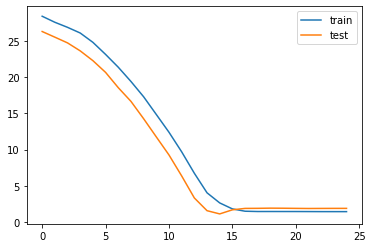


predict: [[31.652523 24.0406  ]]
real:      [[31.2 22.3]]

Train on 1007 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 28.4123 - mean_squared_error: 843.5112 - val_loss: 26.7567 - val_mean_squared_error: 731.6930
Epoch 2/1000
 - 0s - loss: 27.6699 - mean_squared_error: 804.1327 - val_loss: 25.9747 - val_mean_squared_error: 693.9323
Epoch 3/1000
 - 0s - loss: 26.9500 - mean_squared_error: 767.8122 - val_loss: 25.0738 - val_mean_squared_error: 650.7238
Epoch 4/1000
 - 0s - loss: 26.0329 - mean_squared_error: 719.7841 - val_loss: 23.9739 - val_mean_squared_error: 596.9097
Epoch 5/1000
 - 0s - loss: 24.7845 - mean_squared_error: 657.0366 - val_loss: 22.6245 - val_mean_squared_error: 535.4340
Epoch 6/1000
 - 0s - loss: 23.4269 - mean_squared_error: 592.1732 - val_loss: 21.1912 - val_mean_squared_error: 472.4186
Epoch 7/1000
 - 0s - loss: 21.9131 - mean_squared_error: 525.3006 - val_loss: 19.4745 - val_mean_squared_error: 404.2676
Epoch 8/1000
 - 0s - loss: 20.0642 - mean_square

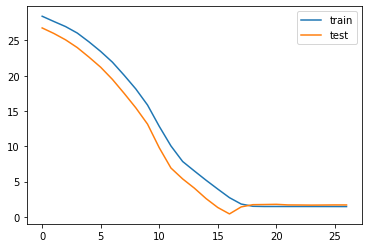


predict: [[31.292828 23.366596]]
real:      [[31.1 22.3]]

Train on 1006 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 27.7091 - mean_squared_error: 804.0381 - val_loss: 25.8211 - val_mean_squared_error: 683.6551
Epoch 2/1000
 - 0s - loss: 26.5265 - mean_squared_error: 738.0637 - val_loss: 24.7022 - val_mean_squared_error: 626.8906
Epoch 3/1000
 - 0s - loss: 25.3812 - mean_squared_error: 677.6878 - val_loss: 23.4894 - val_mean_squared_error: 568.3451
Epoch 4/1000
 - 0s - loss: 24.0189 - mean_squared_error: 608.4316 - val_loss: 22.0723 - val_mean_squared_error: 502.2779
Epoch 5/1000
 - 0s - loss: 22.2406 - mean_squared_error: 522.9355 - val_loss: 19.8122 - val_mean_squared_error: 403.5328
Epoch 6/1000
 - 0s - loss: 20.0512 - mean_squared_error: 427.0490 - val_loss: 17.5868 - val_mean_squared_error: 319.0862
Epoch 7/1000
 - 0s - loss: 17.4232 - mean_squared_error: 326.9330 - val_loss: 14.6504 - val_mean_squared_error: 223.2174
Epoch 8/1000
 - 0s - loss: 14.4108 - mean_square

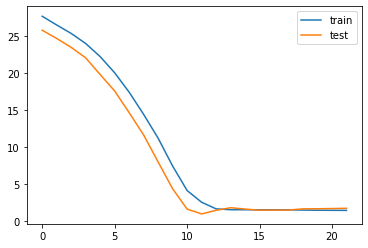


predict: [[32.461002 23.882816]]
real:      [[31.  22.8]]

Train on 1005 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 27.8711 - mean_squared_error: 812.7469 - val_loss: 25.8604 - val_mean_squared_error: 686.2290
Epoch 2/1000
 - 0s - loss: 26.9472 - mean_squared_error: 762.3336 - val_loss: 24.8045 - val_mean_squared_error: 630.6102
Epoch 3/1000
 - 0s - loss: 25.6549 - mean_squared_error: 691.8406 - val_loss: 23.3411 - val_mean_squared_error: 559.3173
Epoch 4/1000
 - 0s - loss: 23.8133 - mean_squared_error: 599.9626 - val_loss: 21.3464 - val_mean_squared_error: 468.8002
Epoch 5/1000
 - 0s - loss: 21.3491 - mean_squared_error: 486.3661 - val_loss: 18.6067 - val_mean_squared_error: 357.6991
Epoch 6/1000
 - 0s - loss: 18.0416 - mean_squared_error: 353.5317 - val_loss: 14.9041 - val_mean_squared_error: 232.0616
Epoch 7/1000
 - 0s - loss: 14.7180 - mean_squared_error: 241.1007 - val_loss: 11.3641 - val_mean_squared_error: 136.9799
Epoch 8/1000
 - 0s - loss: 10.9657 - mean_square

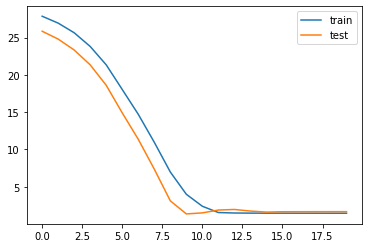


predict: [[29.645535 24.36566 ]]
real:      [[31.5 23. ]]

Train on 1004 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 27.7381 - mean_squared_error: 806.3202 - val_loss: 26.3257 - val_mean_squared_error: 711.0521
Epoch 2/1000
 - 0s - loss: 26.6787 - mean_squared_error: 747.9118 - val_loss: 25.4446 - val_mean_squared_error: 664.4359
Epoch 3/1000
 - 0s - loss: 25.6623 - mean_squared_error: 694.9528 - val_loss: 24.2118 - val_mean_squared_error: 603.2962
Epoch 4/1000
 - 0s - loss: 24.2013 - mean_squared_error: 623.9956 - val_loss: 21.9480 - val_mean_squared_error: 500.1236
Epoch 5/1000
 - 0s - loss: 22.1735 - mean_squared_error: 532.5605 - val_loss: 19.7608 - val_mean_squared_error: 409.8566
Epoch 6/1000
 - 0s - loss: 19.9299 - mean_squared_error: 435.9781 - val_loss: 17.2639 - val_mean_squared_error: 314.7253
Epoch 7/1000
 - 0s - loss: 17.3871 - mean_squared_error: 337.3459 - val_loss: 14.7524 - val_mean_squared_error: 229.6911
Epoch 8/1000
 - 0s - loss: 14.1058 - mean_square

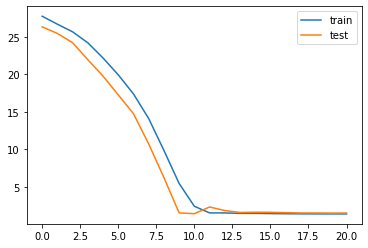


predict: [[33.511925 23.741415]]
real:      [[30.9 22.9]]

Train on 1003 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 28.2897 - mean_squared_error: 838.1069 - val_loss: 25.3929 - val_mean_squared_error: 668.0241
Epoch 2/1000
 - 0s - loss: 27.6291 - mean_squared_error: 797.5850 - val_loss: 24.8183 - val_mean_squared_error: 637.3336
Epoch 3/1000
 - 0s - loss: 26.9227 - mean_squared_error: 756.2773 - val_loss: 24.1803 - val_mean_squared_error: 604.0750
Epoch 4/1000
 - 0s - loss: 25.9715 - mean_squared_error: 703.2892 - val_loss: 23.2310 - val_mean_squared_error: 557.5617
Epoch 5/1000
 - 0s - loss: 24.9254 - mean_squared_error: 646.7779 - val_loss: 21.9113 - val_mean_squared_error: 493.7936
Epoch 6/1000
 - 0s - loss: 23.7578 - mean_squared_error: 585.5621 - val_loss: 20.7148 - val_mean_squared_error: 439.4310
Epoch 7/1000
 - 0s - loss: 22.3023 - mean_squared_error: 514.4870 - val_loss: 19.0661 - val_mean_squared_error: 370.7907
Epoch 8/1000
 - 0s - loss: 20.3202 - mean_square

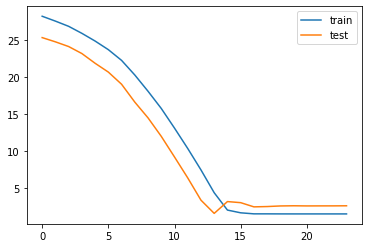


predict: [[32.85071  19.776093]]
real:      [[31.2 23.2]]

Train on 1002 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 28.3646 - mean_squared_error: 837.2713 - val_loss: 25.4762 - val_mean_squared_error: 655.3064
Epoch 2/1000
 - 0s - loss: 27.7423 - mean_squared_error: 795.4195 - val_loss: 24.9654 - val_mean_squared_error: 626.8816
Epoch 3/1000
 - 0s - loss: 27.0087 - mean_squared_error: 749.1719 - val_loss: 24.0676 - val_mean_squared_error: 580.5692
Epoch 4/1000
 - 0s - loss: 26.1887 - mean_squared_error: 701.1531 - val_loss: 23.1905 - val_mean_squared_error: 538.1431
Epoch 5/1000
 - 0s - loss: 25.2327 - mean_squared_error: 648.3068 - val_loss: 22.1587 - val_mean_squared_error: 491.0095
Epoch 6/1000
 - 0s - loss: 23.8817 - mean_squared_error: 578.3196 - val_loss: 20.4738 - val_mean_squared_error: 420.5771
Epoch 7/1000
 - 0s - loss: 22.1315 - mean_squared_error: 494.8753 - val_loss: 18.5150 - val_mean_squared_error: 347.2343
Epoch 8/1000
 - 0s - loss: 20.0232 - mean_square

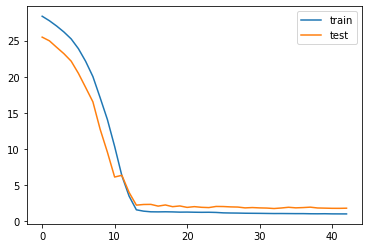


predict: [[32.64586  22.814043]]
real:      [[31.  21.1]]

Train on 1001 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 27.5901 - mean_squared_error: 797.1766 - val_loss: 24.7730 - val_mean_squared_error: 624.2026
Epoch 2/1000
 - 0s - loss: 26.0524 - mean_squared_error: 709.9269 - val_loss: 23.5278 - val_mean_squared_error: 563.5267
Epoch 3/1000
 - 0s - loss: 24.7377 - mean_squared_error: 639.8383 - val_loss: 22.0429 - val_mean_squared_error: 492.9880
Epoch 4/1000
 - 0s - loss: 23.1110 - mean_squared_error: 558.3469 - val_loss: 20.4212 - val_mean_squared_error: 422.1719
Epoch 5/1000
 - 0s - loss: 21.3654 - mean_squared_error: 478.4202 - val_loss: 18.7187 - val_mean_squared_error: 354.8445
Epoch 6/1000
 - 0s - loss: 19.2946 - mean_squared_error: 392.0962 - val_loss: 16.1869 - val_mean_squared_error: 265.4909
Epoch 7/1000
 - 0s - loss: 17.0806 - mean_squared_error: 309.7080 - val_loss: 13.9063 - val_mean_squared_error: 196.0699
Epoch 8/1000
 - 0s - loss: 14.7340 - mean_square

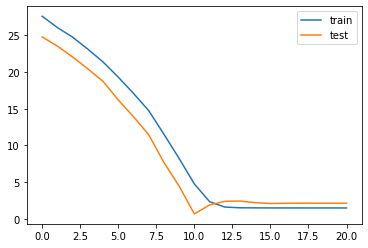


predict: [[29.326262 22.347486]]
real:      [[28.7 22.8]]

Train on 1000 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 28.0973 - mean_squared_error: 824.8550 - val_loss: 25.8671 - val_mean_squared_error: 685.4552
Epoch 2/1000
 - 0s - loss: 27.4981 - mean_squared_error: 790.7212 - val_loss: 25.1923 - val_mean_squared_error: 653.6748
Epoch 3/1000
 - 0s - loss: 26.5569 - mean_squared_error: 738.8020 - val_loss: 24.1247 - val_mean_squared_error: 601.4054
Epoch 4/1000
 - 0s - loss: 25.4749 - mean_squared_error: 680.6096 - val_loss: 23.0758 - val_mean_squared_error: 550.3300
Epoch 5/1000
 - 0s - loss: 24.2295 - mean_squared_error: 617.0749 - val_loss: 21.6641 - val_mean_squared_error: 485.2139
Epoch 6/1000
 - 0s - loss: 22.8477 - mean_squared_error: 550.6819 - val_loss: 20.2002 - val_mean_squared_error: 423.4220
Epoch 7/1000
 - 0s - loss: 20.9493 - mean_squared_error: 464.5509 - val_loss: 17.9299 - val_mean_squared_error: 334.5567
Epoch 8/1000
 - 0s - loss: 18.5408 - mean_square

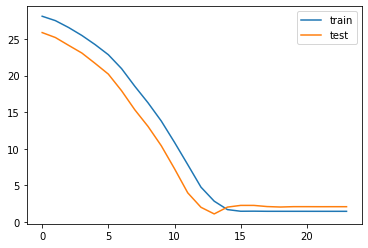


predict: [[31.55324 23.67989]]
real:      [[30.1 22.9]]

Test RMSE -------------------------- 21.07
Test VARIANCE ---------------------- 1.0
Test MAX-ERROR --------------------- 29.7
Test MEAN-ABSOLUTE-ERROR ----------- 16.0
Test MEDIAN-ABSOLUTE-ERROR --------- 16.0


In [11]:
# to get index the last 30 days
days_to_predict = list(dataset.index[-30:])

NCV(dataset, days_to_predict)